Clone the github repository to train Mask RCNN model with Home objects dataset

In [0]:
!git clone https://gitlab.com/sudheer2015/homeobjects_mask_rcnn_bottle

Cloning into 'homeobjects_mask_rcnn_bottle'...
remote: Enumerating objects: 393, done.
remote: Counting objects: 100% (393/393), done.
remote: Compressing objects: 100% (271/271), done.
remote: Total 393 (delta 130), reused 372 (delta 120), pack-reused 0
Receiving objects: 100% (393/393), 297.53 MiB | 10.28 MiB/s, done.
Resolving deltas: 100% (130/130), done.
Checking out files: 100% (364/364), done.


In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


**Note:** This project doesn't support '**tensorflow.keras**'. Use '**Keras**' library with tensorflow backend instead.
Training time on CPU: 1 epoch - 1 hr
Training time on GPU: 1 epoch - 1.5 mins

### Dataset
http://www.vision.caltech.edu/pmoreels/Datasets/Home_Objects_06/

### VGG mask annotation tool
**Note:** Use v2.0.8
http://www.robots.ox.ac.uk/~vgg/software/via/

### Requirements
1. numpy
2. scipy
3. Pillow
4. cython
5. matplotlib
6. scikit-image
7. tensorflow>=1.14.0
8. keras>=2.5.4
9. opencv-python>=3.0
10. h5py
11. imgaug
12. IPython[all]




# Report
## Introduction
Training Mask RCNN from scratch is very computationally intense and expensive task and could take several days to fully converge to a optimal point even with a good GPU. So, instead of training the model from scratch, I used Mask RCNN pretrained frozen weights, trained on Coco dataset as the starting point, and build training on top of it using 'home objects' dataset. This approach is also referred as transfer learning, and is widely used nowadays.

The Home Objects dataset has 101 training samples with 101 household objects from kitchen, living room and, garden. The training set contains images with various objects, i.e one object per image and, the test set contains multiple objects per sample (image).

## Description

To begin with, I started by downloading the '**HomeObjects** dataset from [Caltech](http://www.vision.caltech.edu/pmoreels/Datasets/Home_Objects_06/) and [Mask-RCNN](https://github.com/matterport/Mask_RCNN) code by Matterport from the github repo website. I followed the 'balloon', and 'Coco' examples to train this model.

Initially I considered several tools for annotating the images but, I finally went with the VGG Image Annotator tool, as it was convinient to use and provided clear interface.

The annotation procedure is fairly simple, but tedious. I drew a polyline around the object and annoted it with the object name. In this case, the object name is the filename itself. I followed the same procedure with the rest of the images. After annotating all images, I exported the the mask data as a json file.

The '**load_mask**' function in '**bottle**' program uses this json file to extract image masks from images in real-time.

### Various steps involved in this project

1. Image pre-processing - Mask extraction from the image, and resizing the images and masks to (1, 1024, 1024, 3), and (1, 1024, 1024, instances) respectively, where instances is number of masks in a sample (1 in this case, since each sample has only one object in it).
2. Pre-training Mask RCNN model with mask_rcnn_coco weights.
3. Training 'heads' layers of Resnet50 backbone model for several epochs (300 epochs) with HomeObjects dataset.
4. Training '**all**' layers of Mask RCNN model for several epochs (300 epochs) with HomeObjects dataset.
5. Training '**all**' layers of Mask RCNN model for several epochs (300 epochs) with HomeObjects dataset using data augmentation.


# Challenges

Mask realign problem: Some images were flipped when loaded by the program that caused the mask and image realignment. So I added a custom function to traspose, and flip the image. 

### References
1. https://www.kaggle.com/hmendonca/mask-rcnn-and-coco-transfer-learning-lb-0-155/notebook
2. https://machinelearningmastery.com/how-to-perform-object-detection-in-photographs-with-mask-r-cnn-in-keras/
3. https://towardsdatascience.com/object-detection-using-mask-r-cnn-on-a-custom-dataset-4f79ab692f6d
4. https://towardsdatascience.com/object-detection-using-mask-r-cnn-on-a-custom-dataset-4f79ab692f6d

### Imports and paths ###


In [0]:
# Verify whether COCO checkpoint file is loaded currently
import os
assert os.path.exists('/content/drive/My Drive/MaskRCNNCoco/checkpoints/mask_rcnn_coco.h5')

In [0]:
# Matplotlib images plotted inline
%matplotlib inline 

In [0]:
# Test GPU instance
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [0]:
# Supress ignore warnings
import warnings 
warnings.filterwarnings("ignore")

In [0]:
import sys
sys.path.append("/content/homeobjects_mask_rcnn_bottle")

from mrcnn.config import Config
import bottle
from bottle import CustomConfig, CustomDataset

### Mask RCNN configuration

In [0]:
HOME_OBJECTS_DIR = "/content/homeobjects_mask_rcnn_bottle/dataset"
dataset = CustomDataset()
dataset.load_custom(HOME_OBJECTS_DIR, "train")

# Must call before using the dataset
dataset.prepare()

In [0]:
# Lets examine the dataset
config.display()


Configurations:
BACKBONE                       resnet50
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     2
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        50
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 2
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  1024
IMAGE_META_SIZE                114
IMAGE_MIN_DIM                  800
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [1024 1024    3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  5e-05
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE          

### Class labels information

In [0]:
print("Image Count: {}".format(len(dataset.image_ids)))
print("Class Count: {}".format(dataset.num_classes))

for temp in dataset.class_info:
  print("Class ID: {}, Class name: {}".format(temp['id'], temp['name']))

Image Count: 101
Class Count: 102
Class ID: 0, Class name: BG
Class ID: 1, Class name: P1020693
Class ID: 2, Class name: P1020597
Class ID: 3, Class name: P1030124
Class ID: 4, Class name: P1020631
Class ID: 5, Class name: P1030105
Class ID: 6, Class name: P1030121
Class ID: 7, Class name: P1020696
Class ID: 8, Class name: P1030114
Class ID: 9, Class name: P1020651
Class ID: 10, Class name: P1030159
Class ID: 11, Class name: P1030123
Class ID: 12, Class name: P1020691
Class ID: 13, Class name: P1020823
Class ID: 14, Class name: P1020771
Class ID: 15, Class name: P1020767
Class ID: 16, Class name: P1020739
Class ID: 17, Class name: P1020611
Class ID: 18, Class name: P1030129
Class ID: 19, Class name: P1020583
Class ID: 20, Class name: P1030144
Class ID: 21, Class name: P1020598
Class ID: 22, Class name: P1020692
Class ID: 23, Class name: P1030115
Class ID: 24, Class name: P1020812
Class ID: 25, Class name: P1030134
Class ID: 26, Class name: P1020699
Class ID: 27, Class name: P1030162
Cl

### Images and masks visualization

['BG', 'P1020693', 'P1020597', 'P1030124', 'P1020631', 'P1030105', 'P1030121', 'P1020696', 'P1030114', 'P1020651', 'P1030159', 'P1030123', 'P1020691', 'P1020823', 'P1020771', 'P1020767', 'P1020739', 'P1020611', 'P1030129', 'P1020583', 'P1030144', 'P1020598', 'P1020692', 'P1030115', 'P1020812', 'P1030134', 'P1020699', 'P1030162', 'P1020643', 'P1020640', 'P1020697', 'P1030145', 'P1030146', 'P1030165', 'P1020635', 'P1020619', 'P1020770', 'P1020617', 'P1020706', 'P1020777', 'P1020776', 'P1030111', 'P1020645', 'P1030149', 'P1020716', 'P1020629', 'P1020595', 'P1030164', 'P1030138', 'P1020590', 'P1030112', 'P1020626', 'P1020665', 'P1030104', 'P1030173', 'P1030157', 'P1030156', 'P1020701', 'P1020712', 'P1020670', 'P1030107', 'P1020724', 'P1020723', 'P1020773', 'P1020698', 'P1030116', 'P1020689', 'P1030128', 'P1030154', 'P1020769', 'P1020757', 'P1030113', 'P1020623', 'P1030127', 'P1020695', 'P1030153', 'P1020664', 'P1030158', 'P1020822', 'P1030150', 'P1020813', 'P1020772', 'P1030109', 'P1020726

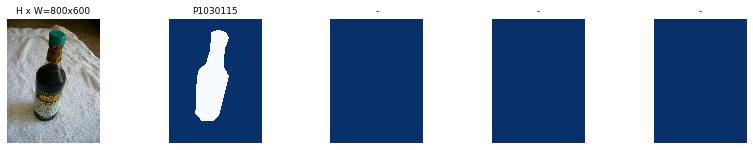

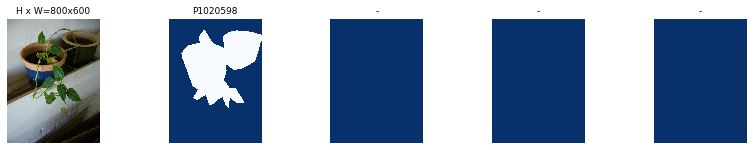

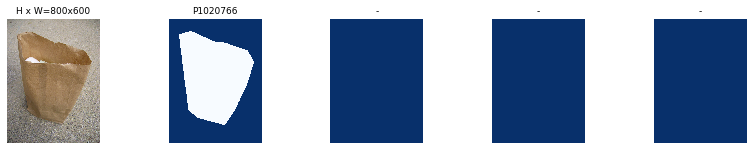

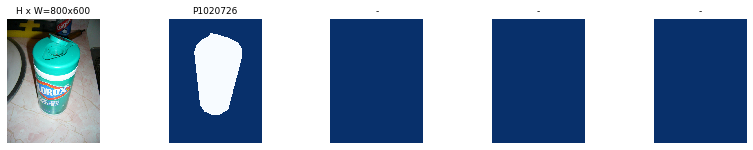

In [0]:
# Display images and masks
# Load and display random samples
import numpy as np
from mrcnn import utils
from mrcnn import visualize
from mrcnn.visualize import display_images
image_ids = np.random.choice(dataset.image_ids, 4)

print(dataset.class_names)

# Add 1 to the image_ids since 0 is background
for image_id in image_ids:
    image = dataset.load_image(image_id)
    mask, class_ids = dataset.load_mask(image_id)
    visualize.display_top_masks(image, mask, class_ids, dataset.class_names)

image_id  89 None
image                    shape: (600, 800, 3)         min:    0.00000  max:  255.00000  uint8
mask                     shape: (600, 800, 1)         min:    0.00000  max:    1.00000  bool
class_ids                shape: (1,)                  min:   45.00000  max:   45.00000  int32
bbox                     shape: (1, 4)                min:   41.00000  max:  741.00000  int32


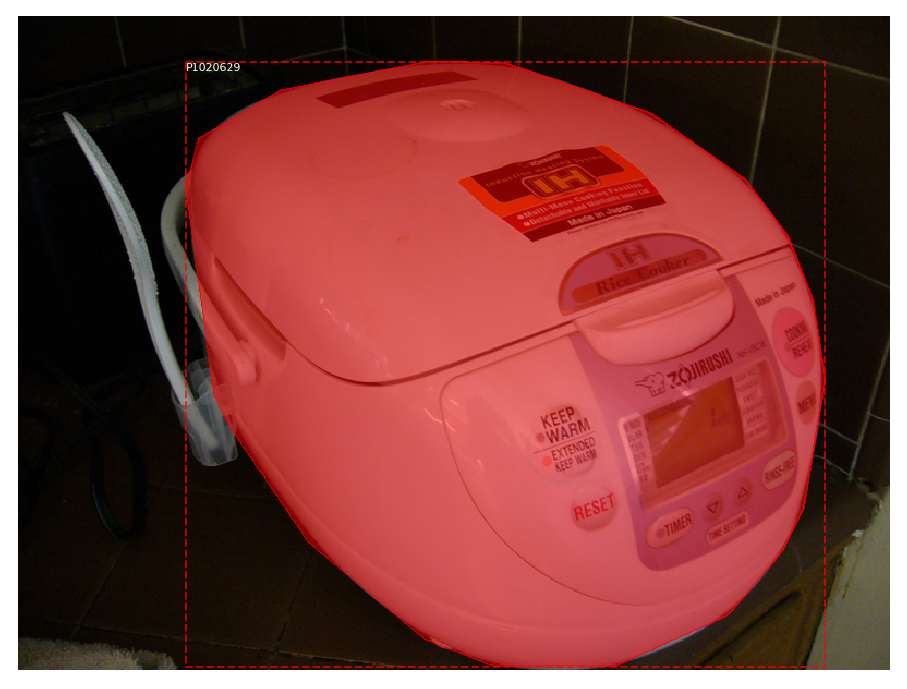

In [0]:
import random
import mrcnn.model as modellib
from mrcnn.model import log

# Load random image and mask.
image_id = random.choice(dataset.image_ids)

image = dataset.load_image(image_id)
mask, class_ids = dataset.load_mask(image_id)

# Compute Bounding box
bbox = utils.extract_bboxes(mask)

# Display image and additional stats
print("image_id ", image_id, dataset.image_reference(image_id))
class_ids = np.array((dataset.image_info[image_id]['class_id'], ), dtype=np.int32)

log("image", image)
log("mask", mask)
log("class_ids", class_ids)
log("bbox", bbox)

# Display image and instances
visualize.display_instances(image, bbox, mask, class_ids, dataset.class_names)

### Resize and augmentation

mask                     shape: (1024, 1024, 1)       min:    0.00000  max:    1.00000  bool


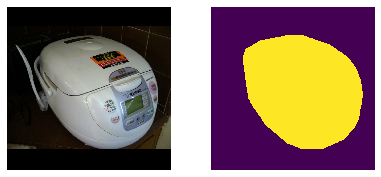

In [0]:
# Mask RCNN Resnet 50 Coco requires input images to be of shape 
# (1024, 1024, 3) and masks to (1024, 1024, num_instances) 
# Resize images and mask by adding zero padding
image, image_meta, class_ids, bbox, mask = modellib.load_image_gt(
    dataset, config, image_id, augment=False, use_mini_mask=False)
log("mask", mask)
display_images([image]+[mask[:,:,i] for i in range(min(mask.shape[-1], 7))])

### Transfer learning using coco dataset

In [0]:
# Train from start using Coco dataset
# Change COCO_WEIGHTS_DIR in bottle.py to 'mask_rcnn_coco.h5' model file
!python3 /content/homeobjects_mask_rcnn_bottle/bottle.py train --dataset=/content/homeobjects_mask_rcnn_bottle/dataset --weights=coco

### Resume training from a checkpoint

In [0]:
# Resume training from a checkpoint
# Restarts training from the last epoch
# Change COCO_WEIGHTS_DIR in bottle.py to 'logs/bottle20200209T0841/mask_rcnn_bottle_0180.h5' model file
!python3 /content/homeobjects_mask_rcnn_bottle/bottle.py train --dataset=/content/homeobjects_mask_rcnn_bottle/dataset --weights=coco

Using TensorFlow backend.
Weights:  coco
Dataset:  /content/homeobjects_mask_rcnn_bottle/dataset
Logs:  /content/drive/My Drive/MaskRCNNCoco/logs

Configurations:
BACKBONE                       resnet50
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     2
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        50
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 2
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  1024
IMAGE_META_SIZE                114
IMAGE_MIN_DIM                  800
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [1024 1024    3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  5e-05
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rp

## Useful links
### Tensorboard colab
1. https://medium.com/@tommytao_54597/use-tensorboard-in-google-colab-16b4bb9812a6
2. https://www.dlology.com/blog/quick-guide-to-run-tensorboard-in-google-colab/
3. https://stackoverflow.com/questions/47818822/can-i-use-tensorboard-with-google-colab

### Adam optimizer
1. https://www.tensorflow.org/versions/r1.15/api_docs/python/tf/keras/optimizers/Adam
2. https://keras.io/optimizers/#adam

### Model checkpoint
1. https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/ModelCheckpoint

### Pickle serialization
1. https://pythonprogramming.net/python-pickle-module-save-objects-serialization/

### Colab from disconnecting 
1. https://medium.com/@shivamrawat_756/how-to-prevent-google-colab-from-disconnecting-717b88a128c0

### Issues
Training model gets stuck at first epoch: 
1. https://github.com/matterport/Mask_RCNN/issues/287
2. https://github.com/googlecolab/colabtools/issues/83